# Importing libraries

In [5]:
%pip install osmnx
%pip install rasterio
%pip install rasterstats
%pip install contextily
%pip install geopandas
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [6]:
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
import random
from shapely.geometry import box
import contextily as ctx
import rasterio
from scipy.spatial import cKDTree
from rasterstats import zonal_stats
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

# Data

In [7]:
EV_ukr = 135200
population_ukr = 31000000
EV_per_capita_ukr = EV_ukr/population_ukr
print("Number of EV per capita:", round(EV_per_capita_ukr, 5))

Number of EV per capita: 0.00436


In [66]:
city_data_lviv = {
    "place": 'Lviv, Ukraine',
    "grid_size": 0.0125,
    "EV_per_capita": EV_per_capita_ukr,
    "distance_matrix": "distance_matrix_lviv1.npy",
    "raster_file_population": "ukr_ppp_2020_constrained.tif"
}

EV_data_lviv = {
    "avg_consumption_per_km": 159.9,
    "avg_distance_per_day": 33,
    "max_distance_to_charger": 3000
}

CS_data_lviv = {
    "energy_loss": 0.01,
    "station_utilization_rate": 0.15,
    "max_stations_num": 4,
    "CS_list": ["Level_2 7.4kW", "Level_2 22kW", "Level_2 50kW", "Level_3 60kW", "Level_3 120kW", "Level_3 160kW"],
    "Level_2 7.4kW": {"cost":2000, "capacity":7.4*1000, "voltage": 240},
    "Level_2 22kW": {"cost":5000, "capacity":22*1000, "voltage": 240},
    "Level_2 50kW": {"cost":7200, "capacity":50*1000, "voltage": 240},
    "Level_3 60kW": {"cost":10000, "capacity":60*1000, "voltage": 480},
    "Level_3 120kW": {"cost":30000, "capacity":120*1000, "voltage": 480},
    "Level_3 160kW": {"cost":50000, "capacity":160*1000, "voltage": 480},
    "installed_stations": "station_location_lviv.csv"
}

model_parameters_lviv = {
    "alpha": 10,
    "beta": 0.001,
    "gamma": 1,
    "lambda": 20,
    "iterations":10,
    "w": 0.3,
    "c1": 1.5,
    "c2": 1.5,
}

In [67]:
city_data = city_data_lviv
EV_data = EV_data_lviv
CS_data = CS_data_lviv
model_parameters = model_parameters_lviv

# City graph

In [13]:
G = ox.graph_from_place(city_data["place"], network_type="drive")

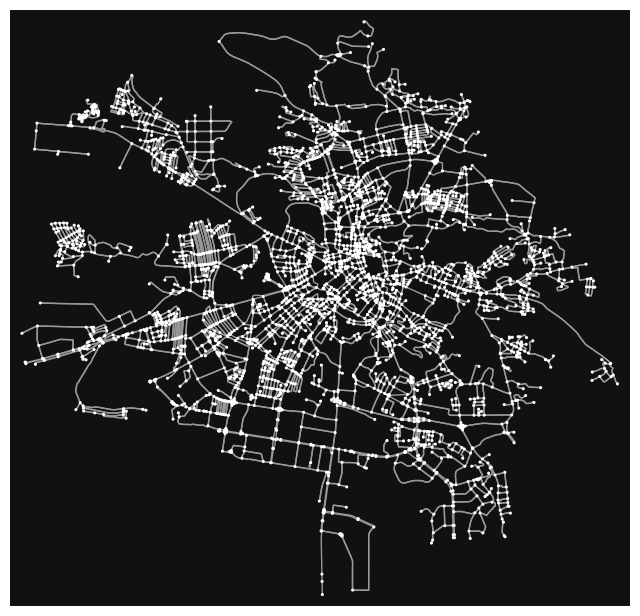

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [14]:
ox.plot_graph(G, node_size=5)

# Adding installed charging stations

**The form in which installed stations are presented:**\
$y\ =\ \{$ \
$\ \ \ \ (i, station\_capacity): n$ \
$\}$

Where\
$i$ - node_id,\
$n$ - number of stations (of this type) in the node $i$

In [10]:
def add_charging_stations(G, CS_data, visualization = True):
    charging_stations = pd.read_csv(CS_data["installed_stations"], sep = ";")
    # print(charging_stations.head())
    installed_cs = dict()
    installed_cs_list = []
    for row_index in range(len(charging_stations)):
        latitude = charging_stations['X'][row_index]
        longitude = charging_stations['Y'][row_index]
        num_of_chargers = charging_stations['Number'][row_index]
        cs_capacity = charging_stations['Capacity'][row_index]
        station_point = Point(longitude, latitude)

        # Найближче ребро (u, v, key) and its geometry
        u, v, key = ox.distance.nearest_edges(G, longitude, latitude)

        edge_data = G.get_edge_data(u, v, key)
        geom = edge_data.get("geometry", LineString([(G.nodes[u]['x'], G.nodes[u]['y']),
                                                    (G.nodes[v]['x'], G.nodes[v]['y'])]))

        # Найближча точка на ребрі
        line = LineString(geom)
        closest_point = line.interpolate(line.project(station_point))
        # new_node_id = (closest_point.x, closest_point.y)
        new_node_id = max(G.nodes) + 1
        G.add_node(new_node_id, x=closest_point.x, y=closest_point.y)

        # Поділ ребра на два ребра
        if G.has_edge(u, v, key):
            G.remove_edge(u, v, key)
            G.add_edge(u, new_node_id, length=line.project(closest_point))
            G.add_edge(new_node_id, v, length=line.length - line.project(closest_point))
        
        if G.has_edge(v, u, key):
            G.remove_edge(v, u, key)
            G.add_edge(v, new_node_id, length=line.project(closest_point))
            G.add_edge(new_node_id, u, length=line.length - line.project(closest_point))

        if new_node_id not in installed_cs_list:
            installed_cs_list.append(new_node_id)
        installed_cs[(new_node_id, cs_capacity)] = num_of_chargers

    if visualization:
        pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}
        G_lviv_undirected = G.to_undirected()
        G_lviv_undirected.remove_edges_from(nx.selfloop_edges(G_lviv_undirected))
        fig, ax = plt.subplots(figsize=(12, 9), facecolor="black")

        nx.draw(G_lviv_undirected, pos, node_size=3, with_labels=False, node_color="white", edge_color="white", ax=ax)
        nx.draw_networkx_nodes(
        G_lviv_undirected, pos, nodelist=installed_cs_list, node_size=10, node_color="orange", label="Installed Stations", ax=ax)

        legend = plt.legend(scatterpoints=1, frameon=True, loc="upper right", facecolor="black", edgecolor="white", bbox_to_anchor=(1.5, 1))
        for text in legend.get_texts():
            text.set_color("white")

        plt.title("Graph with Installed Stations", color="white")
        ax.axis("off")
        fig.patch.set_facecolor("black")
        ax.set_facecolor("black")
        plt.tight_layout()
        plt.show()
    return G, installed_cs, installed_cs_list

# Capacity demand prediction

### Division into sectors

In [11]:
def division_into_secors(city_data):
    city_boundary = ox.geocode_to_gdf(city_data["place"])

    xmin, ymin, xmax, ymax = city_boundary.total_bounds
    grid_size = 0.0125

    grid_cells = []
    for x in np.arange(xmin, xmax, grid_size):
        for y in np.arange(ymin, ymax, grid_size):
            grid_cells.append(box(x, y, x + grid_size, y + grid_size))

    grid = gpd.GeoDataFrame(geometry=grid_cells, crs=city_boundary.crs)
    map_with_grid = gpd.clip(grid, city_boundary)

    # ax = map_with_grid.plot(edgecolor="rosybrown", facecolor="none", figsize=(10, 10))
    # city_boundary.boundary.plot(ax=ax, color="maroon")
    # ctx.add_basemap(ax, crs=city_boundary.crs, source=ctx.providers.CartoDB.Positron)
    return map_with_grid, city_boundary

Assigning graph nodes to a grid cell (region)

In [12]:
def nodes_to_region(G, map_with_grid):
    nodes_gdf, edges_gdf = ox.graph_to_gdfs(G, nodes=True, edges=True)
    nodes_gdf = nodes_gdf.set_geometry(nodes_gdf.geometry)

    nodes_in_grid = gpd.sjoin(nodes_gdf, map_with_grid, how="left", predicate="within")
    nodes_in_grid = nodes_in_grid.reset_index()

    # Handling nodes that are not assigned to any grid cell. Creating node to region dictionary and region to nodes dictiionary
    assigned_nodes = nodes_in_grid.dropna(subset=['index_right']) 
    missing_nodes = nodes_in_grid[nodes_in_grid['index_right'].isna()]

    tree = cKDTree(assigned_nodes[['x', 'y']].values)
    _, nearest_idx = tree.query(missing_nodes[['x', 'y']].values)

    nodes_in_grid.loc[nodes_in_grid['index_right'].isna(), 'index_right'] = assigned_nodes.iloc[nearest_idx]['index_right'].values
    nodes_in_grid['index_right'] = nodes_in_grid['index_right'].astype(int)

    # region -> list of nodes
    region_to_nodes = nodes_in_grid.groupby(nodes_in_grid.index_right)['osmid'].apply(list).to_dict()
    # node -> region DI
    node_to_region = nodes_in_grid.set_index('osmid')['index_right'].to_dict()
    regions = [region for region in region_to_nodes]
    return regions, region_to_nodes, node_to_region


In [13]:
# map_with_grid = map_with_grid.to_crs(epsg=4326)
# edges_gdf = edges_gdf.to_crs(map_with_grid.crs)
# fig, ax = plt.subplots(figsize=(12, 10))

# map_with_grid.plot(ax=ax, edgecolor="gray", facecolor="none", linewidth=0.5, alpha=0.7, label="Grid")

# edges_gdf.plot(ax=ax, color="darkgray", linewidth=1, alpha=0.8, label="Road Network")
# nodes_gdf.plot(ax=ax, color="red", markersize=5, alpha=0.6, label="Nodes")

# ctx.add_basemap(ax, crs=map_with_grid.crs, source=ctx.providers.CartoDB.Positron)

# ax.set_title(f"Road Network and Grid Overlay in {city_data['place']}", fontsize=14)
# ax.legend()
# plt.show()


### Demand estimation for each region

In [14]:
def demand_estimation(map_with_grid, city_boundary, city_data, visualization = False):

    # Population count for each sector
    raster_file_population = city_data["raster_file_population"]
    with rasterio.open(raster_file_population) as data:
        affine = data.transform
        array = data.read(1)
    stats = zonal_stats(map_with_grid, raster_file_population, stats=["sum"], affine=affine)
    map_with_grid["population"] = [s["sum"] if s["sum"] is not None else 0 for s in stats]
    map_with_grid["density"] = map_with_grid["population"] / map_with_grid.geometry.area

    # Calculation of the number of EV for each sector
    map_with_grid["EV"] = map_with_grid["population"] *city_data["EV_per_capita"]

    # Calculation of charging capacity demand in each region
    avg_consumption_per_km = EV_data["avg_consumption_per_km"] #Wh/km
    avg_distance_per_day = EV_data["avg_distance_per_day"] #km
    energy_loss = CS_data["energy_loss"]
    station_utilization_rate = CS_data["station_utilization_rate"]

    map_with_grid["daily_energy_consumption"] = avg_consumption_per_km * avg_distance_per_day * map_with_grid["EV"]
    map_with_grid["charging_capacity_demand"] = map_with_grid["daily_energy_consumption"]/((1-energy_loss)*station_utilization_rate)

    # Creating region to capacity demand dictionary
    map_with_grid = map_with_grid.reset_index()
    region_to_capacity_demand = dict()
    for grid_cell in range(len(map_with_grid)):
        region_id = map_with_grid.iloc[grid_cell]['index']
        charging_demand = map_with_grid.iloc[grid_cell]['charging_capacity_demand']
        region_to_capacity_demand[region_id] = charging_demand

    # Visualization
    if visualization:
        ax = map_with_grid.plot(column="charging_capacity_demand", cmap="OrRd", edgecolor="rosybrown", legend=True, figsize=(12, 10), alpha =0.6)
        city_boundary.boundary.plot(ax=ax, color="maroon")
        ctx.add_basemap(ax, crs=map_with_grid.crs, source=ctx.providers.CartoDB.Positron)
    
    return region_to_capacity_demand

In [15]:
# ax = map_with_grid.plot(column="charging_capacity_demand", cmap="OrRd", edgecolor="rosybrown", legend=True, figsize=(12, 10), alpha =0.6)
# city_boundary.boundary.plot(ax=ax, color="maroon")
# ctx.add_basemap(ax, crs=map_with_grid.crs, source=ctx.providers.CartoDB.Positron)

# Distance matrix

In [16]:
def calculate_distamnce_matrix(G, nodes):
    nodes = G.nodes
    n = len(nodes)
    print(n)
    node_index = {node: idx for idx, node in enumerate(nodes)}

    D = np.full((n, n), np.inf)

    for u, v, data in G.edges(data=True):
        length = data.get("length", np.inf)
        i, j = node_index[u], node_index[v]
        D[i, j] = length

    for i in range(n): 
        D[i, i] = 0
    
    for k in range(n):
        print(k)
        for i in range(n):
            for j in range(n):
                D[i,j] = min (D[i, j], D[i, k] + D[k, j])
    return D


In [17]:
def distance_matrix(G, city_data):
    if city_data["distance_matrix"]:
        return np.load(city_data["distance_matrix"])
    return calculate_distamnce_matrix(G)

Faster method

In [18]:
from scipy.sparse.csgraph import floyd_warshall
# G = ox.graph_from_place('Dnipro, Ukraine', network_type='drive')
def distance_matrix1(G):
    nodes = list(G.nodes)
    n = len(nodes)
    print(f"Number of nodes: {n}")

    node_index = {node: idx for idx, node in enumerate(nodes)}
    print("Creating adjacency matrix")
    # Create adjacency matrix
    D = np.full((n, n), np.inf)

    for u, v, data in G.edges(data=True):
        length = data.get("length", np.inf)
        i, j = node_index[u], node_index[v]
        D[i, j] = length
        # D[j, i] = length  # Add for undirected graphs

    np.fill_diagonal(D, 0)  # Set diagonal to 0
    print("Using optimized Floyd-Warshall")
    # Use optimized Floyd-Warshall
    D = floyd_warshall(D, directed=True)  # False for undirected graphs
    np.save("distance_matrix_lviv1.npy", D)
    return D
# np.save("distance_matrix_lviv1.npy", distance_matrix1(G))


# Power grid constraints

# Particle Swarm Optimization

**The form in which the solution is presented:**\
$x\ =\ \{$ \
$\ \ \ \ (i, 'station\_type'): n$ \
$\}$

Where\
$i$ - node_id,\
$n$ - number of stations (of this type) in the node $i$

In [19]:
# x = {
#     (i, "level_2_22kw"): 0 for i in range (N)
# }

## Initialization

- 30 solutions
- 5-100 random stations for each solution
- random cs type

In [20]:
def initialize_particles(nodes, station_types, num_particle = 30):
    particles = []
    velocities = []
    for i in range(num_particle):
        solution = {}
        # solution = {(node, cs_type):0 for cs_type in station_types for node in nodes}
        # print(solution)

        velocity = {}
        for node in random.sample(nodes, k=random.randint(5, 100)):
            cs_type = random.choice(station_types)
            cs_number = random.choices([1,2,3], [0.6, 0.3, 0.1])[0]
            solution[(node, cs_type)] = cs_number
            velocity[(node, cs_type)] = 0
        particles.append(solution)
        velocities.append(velocity)
    return particles, velocities

## Fitness Evaluation

### 1) CS cost evaluation

Total CS cost:\
$cs\_cost = \sum^N_{i=1}\sum_{n \in cs\_type} cost_{n,i}*X_{n,i}$

In [21]:
def cs_cost_penalty(solution, CS_data):
    total_cost = 0
    for charging_station in solution:
        cs_type = charging_station[1]
        cost = CS_data[cs_type]["cost"]
        number_of_stations = solution[charging_station]
        total_cost += cost*number_of_stations
    return total_cost

### 2) Coverage penalty evaluation

Coverage penalty takes into account how much the predicted demand for total capacity is greater than the total solution capacity, and it also takes into account how much the average distance from each node to the nearest charging station is greater than the desired maximum distance to charging stations

$coverage\_penalty = \frac{estimated\_demand}{total\_capacity} + \lambda*\frac{dist\_to\_closest\_cs}{max\_dist}$

In [22]:
def calculate_capacity_penalty(solution, region_to_capacity_demand, node_to_region, CS_data, installed_stations):

    capacity_penalty = 0
    region_total_capacity = {region: 0 for region in region_to_capacity_demand}

    # Calculating total capacity for each region
    for charging_station in solution:
        node = charging_station[0]
        cs_type = charging_station[1]
        cs_number = solution[charging_station]
        region = node_to_region[node]
        region_total_capacity[region] = region_total_capacity[region] + CS_data[cs_type]["capacity"]*cs_number

    if installed_stations:
        for charging_station in installed_stations:
            node = charging_station[0]
            cs_capacity = charging_station[1]
            cs_number = installed_stations[charging_station]
            region = node_to_region[node]
            region_total_capacity[region] = region_total_capacity[region] + cs_capacity*cs_number

    # Calculating capacity penalty
    for region in region_to_capacity_demand:
        capacity_penalty +=  region_to_capacity_demand[region]/(region_total_capacity[region]+0.001) # +0.001 to avoid division by zero
    return capacity_penalty

In [23]:
def calculate_distance_penalty(solution, nodes_dict, distance_matrix, max_distance, installed_stations):
    
    total_distance_to_stations = 0
    distance_penalty = 0 
    nodes = list(nodes_dict.keys())
    # Calculating total distance from each node to closest charging station
    for node in nodes:
        distance_list = []
        for charging_station in solution:
            cs_node = charging_station[0]
            # Using nodes_dict to determine node index in distance matrix
            distance = distance_matrix[nodes_dict[node], nodes_dict[cs_node]]
            if distance != float('inf'):
                distance_list.append(distance_matrix[nodes_dict[node], nodes_dict[cs_node]])
        
        if installed_stations:
            for charging_station in installed_stations:
                cs_node = charging_station[0]
                distance = distance_matrix[nodes_dict[node], nodes_dict[cs_node]]
                if distance != float('inf'):
                    distance_list.append(distance_matrix[nodes_dict[node], nodes_dict[cs_node]])
        if len(distance_list)>0:
            total_distance_to_stations += min(distance_list)

    # Calculating distance penalty
    distance_penalty = total_distance_to_stations/(max_distance*len(nodes))
    return distance_penalty

In [24]:
def coverage_penalty(solution, distance_matrix, region_to_capacity_demand, nodes_dict, lambda_parameter, node_to_region, max_distance, CS_data, installed_stations = None):

    capacity_penalty = calculate_capacity_penalty(solution, region_to_capacity_demand, node_to_region, CS_data, installed_stations)
    # print("Capacity penalty:", capacity_penalty)
    distance_penalty = calculate_distance_penalty(solution, nodes_dict, distance_matrix ,max_distance, installed_stations)
    # print("Distance penalty:", distance_penalty)

    penalty = capacity_penalty + lambda_parameter*distance_penalty
    # print("Total coverage penalty:", penalty)
    return penalty

### 3) Grid loss

In [25]:
def total_grid_loss(solution):
    return 1

### Evaluation function

$evaluation = \alpha*cs\_cost + \beta*coverage\_penalty + \gamma*grid\_loss$

In [38]:
def evaluate_fitness(solution, parameters, CS_data, EV_data, distance_matrix, region_to_capacity_demand, node_to_region, nodes_dict, installed_stations):
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    gamma = parameters["gamma"]
    lambdaa = parameters["lambda"]

    cs_cost = cs_cost_penalty(solution, CS_data)
    # print("Cost penalty:", cs_cost)
    coverage = coverage_penalty(solution, distance_matrix, region_to_capacity_demand, nodes_dict,\
                                        lambdaa, node_to_region, EV_data["max_distance_to_charger"], CS_data, installed_stations)
    # print(coverage)
    grid_loss = total_grid_loss(solution)
    # print("Grid loss:", grid_loss)

    fitness = alpha*cs_cost + beta*coverage + gamma*grid_loss
    return fitness, alpha*cs_cost, beta*coverage, gamma*grid_loss

## Update velocities of particles

$v^{t+1}_i = w * v^t_i + c_1*r_1(p_{best} - x_i) + c_2*r_2(g_{best} - x_i) $

- $w$ - inertia weight (controls exploration vs exploitation)\
- $c_1$, $c_2$ - acceleration coefficients (how strongly the particle moves toward the best positions)\
- $r_1$, $r_2$  - random numbers (to add stochastic behavior)\
- $x_i$ - current position of the particle\
- $v_i$ - current velocity of the particle\
- $p_best$ - best position found by the particle\
- $g_best$ - best position found by any particle

In [28]:
def update_velocity(particle, velocity, personal_best, global_best, model_parameters):
    w = model_parameters["w"]
    c1 = model_parameters["c1"]
    c2 = model_parameters["c2"]

    new_velocity = dict()
    all_stations = set(particle.keys())
    all_stations = all_stations.union(personal_best.keys())
    all_stations = all_stations.union(global_best.keys())
    for station in all_stations:

        if station in personal_best:
            p_best_ports = personal_best[station]
        else:
            p_best_ports = 0

        if station in global_best:
            g_best_ports = global_best[station]
        else:
            g_best_ports = 0

        if station in particle:
            particle_ports = particle[station]
        else:
            particle_ports = 0

        p_best_diff = p_best_ports - particle_ports
        g_best_diff = g_best_ports - particle_ports
        
        new_velocity[station] = int(w * velocity.get(station, 0) + c1 * random.random() * p_best_diff + c2 * random.random() * g_best_diff)

    return new_velocity

## Update positions of particles

$x^{t+1}_i = x^t_i + v^{t+1}_i$

In [29]:
def update_particle(particle, velocity, max_ports_per_node):
    new_particle = particle.copy()
    all_stations = velocity.keys()
    num_cs_ports = {cs_node: 0 for cs_node, cs_type in all_stations}

    for station in all_stations:
        change = velocity[station]
        cs_node = station[0]

        if station in new_particle.keys():
            new_particle[station] = max(0, min(max_ports_per_node - num_cs_ports[cs_node], new_particle[station] + change))
        else:
            new_particle[station] = max(0, min(max_ports_per_node - num_cs_ports[cs_node], change))
        
        num_cs_ports[cs_node] = num_cs_ports[cs_node] + new_particle[station]
        if new_particle[station] == 0:
            new_particle.pop(station)
        
    return new_particle

## Check constraints

In [30]:
def check_constraints(_):
    return True

## Fitness plot

In [31]:
def plot_fitness(fitness_list):
    plt.figure(figsize=(7, 5))
    plt.plot(range(len(fitness_list)), fitness_list)
    plt.xlabel('Iteration')
    plt.ylabel('Best fitness')
    plt.title('Fitness value of the best solution for each iteration')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## PSO

In [64]:
def PSO_algorithm(G, dist_matrix, EV_data, CS_data, model_parameters, region_to_capacity_demand, node_to_region, installed_cs = False):
    nodes = list(G.nodes)
    nodes_dict = {nodes[i]: i for i in range(len(nodes))}

    particles, velocities = initialize_particles(nodes, CS_data["CS_list"], num_particle = 30)
    p_best = particles.copy()
    p_best_fitness = [evaluate_fitness(particle, model_parameters, CS_data, EV_data, dist_matrix,\
                                    region_to_capacity_demand, node_to_region, nodes_dict, installed_cs)[0] for particle in particles]
    g_best = p_best[np.argmin(p_best_fitness)]
    g_best_fitness = min(p_best_fitness)

    iterations = model_parameters["iterations"]

    _, fitness_cost, fitness_coverage, fitness_loss = evaluate_fitness(g_best, model_parameters, CS_data, EV_data, dist_matrix,\
                                    region_to_capacity_demand, node_to_region, nodes_dict, installed_cs)
    best_fitness_list = [[g_best_fitness, fitness_cost, fitness_coverage, fitness_loss]]
    
    for n in range(iterations):
        print("Iteration", n + 1, "/", iterations)

        for i in range(len(particles)):
            velocities[i] = update_velocity(particles[i], velocities[i], p_best[i], g_best, model_parameters)
            particles[i] = update_particle(particles[i], velocities[i], CS_data["max_stations_num"])
            current_fitness = evaluate_fitness(particles[i], model_parameters, CS_data, EV_data, dist_matrix,\
                                    region_to_capacity_demand, node_to_region, nodes_dict, installed_cs)[0]
            
            if current_fitness < p_best_fitness[i]:
                p_best[i] = particles[i]
                p_best_fitness[i] = current_fitness

            if current_fitness < g_best_fitness:
                g_best = particles[i]
                g_best_fitness = current_fitness
        _, fitness_cost, fitness_coverage, fitness_loss = evaluate_fitness(g_best, model_parameters, CS_data, EV_data, dist_matrix,\
                                    region_to_capacity_demand, node_to_region, nodes_dict, installed_cs)
        best_fitness_list.append([g_best_fitness, fitness_cost, fitness_coverage, fitness_loss])
        print(f"Best Fitness = {g_best_fitness}")
    # plot_fitness(best_fitness_list)

    return g_best, best_fitness_list


## Visualization

In [53]:
def visualize_solution(solution, G, installed_cs_list = None):

    cs_lists_by_type = dict()
    for charging_station in solution:
        cs_node = charging_station[0]
        cs_type = charging_station[1]
        if cs_type in list(cs_lists_by_type.keys()):
            cs_lists_by_type[cs_type].append(cs_node)
        else:
            cs_lists_by_type[cs_type] = [cs_node]


    pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}
    G_undirected = G.to_undirected()
    G_undirected.remove_edges_from(nx.selfloop_edges(G_undirected))
    fig, ax = plt.subplots(figsize=(12, 9), facecolor="black")

    nx.draw(G_undirected, pos, node_size=5, with_labels=False, node_color="white", edge_color="white", ax=ax)
    
    # Installed stations
    if installed_cs_list:
        nx.draw_networkx_nodes(
            G_undirected, pos, nodelist=installed_cs_list, node_size=20, node_color="orange", label="Initially Installed Stations", ax=ax
        )

    for cs_type in cs_lists_by_type:
        nx.draw_networkx_nodes(
            G_undirected, pos, nodelist=cs_lists_by_type[cs_type], node_size=20, node_color="red", label=f"{cs_type} Stations", ax=ax
        )


    legend = plt.legend(scatterpoints=1, frameon=True, loc="upper right", facecolor="black", edgecolor="white", bbox_to_anchor=(1.5, 1))
    for text in legend.get_texts():
        text.set_color("white")

    plt.title("Graph with Stations", color="white")
    ax.axis("off")

    fig.patch.set_facecolor("black")
    ax.set_facecolor("black")

    plt.tight_layout()
    plt.show()

In [34]:
def visualize_nodes(node_list, G):

    pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}
    G_undirected = G.to_undirected()
    G_undirected.remove_edges_from(nx.selfloop_edges(G_undirected))
    fig, ax = plt.subplots(figsize=(12, 9), facecolor="black")

    nx.draw(G_undirected, pos, node_size=1, with_labels=False, node_color="white", edge_color="white", ax=ax)

    nx.draw_networkx_nodes(
        G_undirected, pos, nodelist=node_list, node_size=30, node_color="green", label="Level 2 Stations", ax=ax
    )

    legend = plt.legend(scatterpoints=1, frameon=True, loc="upper right", facecolor="black", edgecolor="white", bbox_to_anchor=(1.5, 1))
    for text in legend.get_texts():
        text.set_color("white")

    plt.title("Graph", color="white")
    ax.axis("off")

    fig.patch.set_facecolor("black")
    ax.set_facecolor("black")

    plt.tight_layout()
    plt.show()


In [68]:
def plot_models_fitness(best_fitness_lists, parameters):
    m = len(best_fitness_lists)
    plt.figure(figsize=(15, 10))

    for i in range(m):
        
        fitness_list = best_fitness_lists[i]
        fitness = [iteration[0] for  iteration in fitness_list]
        fitness_cost = [iteration[1] for  iteration in fitness_list]
        fitness_coverage = [iteration[2] for  iteration in fitness_list]
        fitness_grid_loss = [iteration[3] for  iteration in fitness_list]
        n = parameters["iterations"] + 1

        plt.subplot((m+1)//2, 2, i+1)
        plt.plot(range(n), fitness, label = "Total evaluation")
        plt.plot(range(n), fitness_cost, label = f"Cost evaluation, weight = {parameters['alpha']}")
        plt.plot(range(n), fitness_coverage, label = f"Coverage evaluation, weight = {parameters['beta']}")
        plt.plot(range(n), fitness_grid_loss, label = f"Grid loss evaluation, weight = {parameters['gamma']}")

        plt.xlabel('Iteration')
        plt.ylabel('Best fitness')
        plt.title(f'Fitness values of the best solution for each iteration for PSO model №{i+1}')
        plt.grid(True)
        plt.legend()

    # plt.figure(figsize=(12, 7))
    # for i in range(n):
    #     plt.plot(range(len(best_fitness_lists[i])), best_fitness_lists[i], label = f"model № {i+1}")
    # plt.xlabel('Iteration')
    # plt.ylabel('Best fitness')
    # plt.title('Fitness value of the best solution for each iteration')
    # plt.grid(True)
    # plt.legend()
    plt.tight_layout()
    plt.show()

# PSO model

In [63]:
def PSO_model(city_data, EV_data, CS_data, model_parameters, n = 4):
    # Graph
    G = ox.graph_from_place(city_data["place"], network_type="drive")

    # Adding installed stations
    G, installed_cs, installed_cs_list = add_charging_stations(G, CS_data, visualization = False)

    # Calculating distance matrix
    dist_matrix = distance_matrix(G, city_data)
    # Division into sectors + demand estimation
    map_with_grid, city_boundary = division_into_secors(city_data)
    regions, region_to_nodes, node_to_region = nodes_to_region(G, map_with_grid)
    region_to_capacity_demand = demand_estimation(map_with_grid, city_boundary, city_data, visualization = False)
    
    # GA
    best_fitness_lists = []
    for i in range(n):
        best_solution, best_fitness_list = PSO_algorithm(G, dist_matrix, EV_data, CS_data, model_parameters,\
                                        region_to_capacity_demand, node_to_region, installed_cs = installed_cs)
        best_fitness_lists.append(best_fitness_list)
    # Visualization
    plot_models_fitness(best_fitness_lists, model_parameters)
    visualize_solution(best_solution, G, installed_cs_list)
    return best_solution

C:\Users\tetia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\shapely\linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
C:\Users\tetia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\shapely\linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
C:\Users\tetia\AppData\Local\Temp\ipykernel_29560\822576114.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  map_with_grid["density"] = map_with_grid["population"] / map_with_grid.geometry.area


Iteration 1 / 10
Best Fitness = 46682077.18296928
Iteration 2 / 10
Best Fitness = 42194870.8285266
Iteration 3 / 10
Best Fitness = 41463695.54654307
Iteration 4 / 10
Best Fitness = 40295445.56125515
Iteration 5 / 10
Best Fitness = 38938277.529731885
Iteration 6 / 10
Best Fitness = 36922738.87680441
Iteration 7 / 10
Best Fitness = 36883685.3479255
Iteration 8 / 10
Best Fitness = 35867406.911290444
Iteration 9 / 10
Best Fitness = 34336920.30275744
Iteration 10 / 10
Best Fitness = 33720398.93025753
Iteration 1 / 10
Best Fitness = 41794820.67277342
Iteration 2 / 10
Best Fitness = 41365387.955608815
Iteration 3 / 10
Best Fitness = 41365387.955608815
Iteration 4 / 10
Best Fitness = 38575194.510318264
Iteration 5 / 10
Best Fitness = 37610860.463401824
Iteration 6 / 10
Best Fitness = 34554066.94282844
Iteration 7 / 10
Best Fitness = 34554066.94282844
Iteration 8 / 10
Best Fitness = 33154298.415493093
Iteration 9 / 10
Best Fitness = 31776210.861303635
Iteration 10 / 10
Best Fitness = 30947661.2

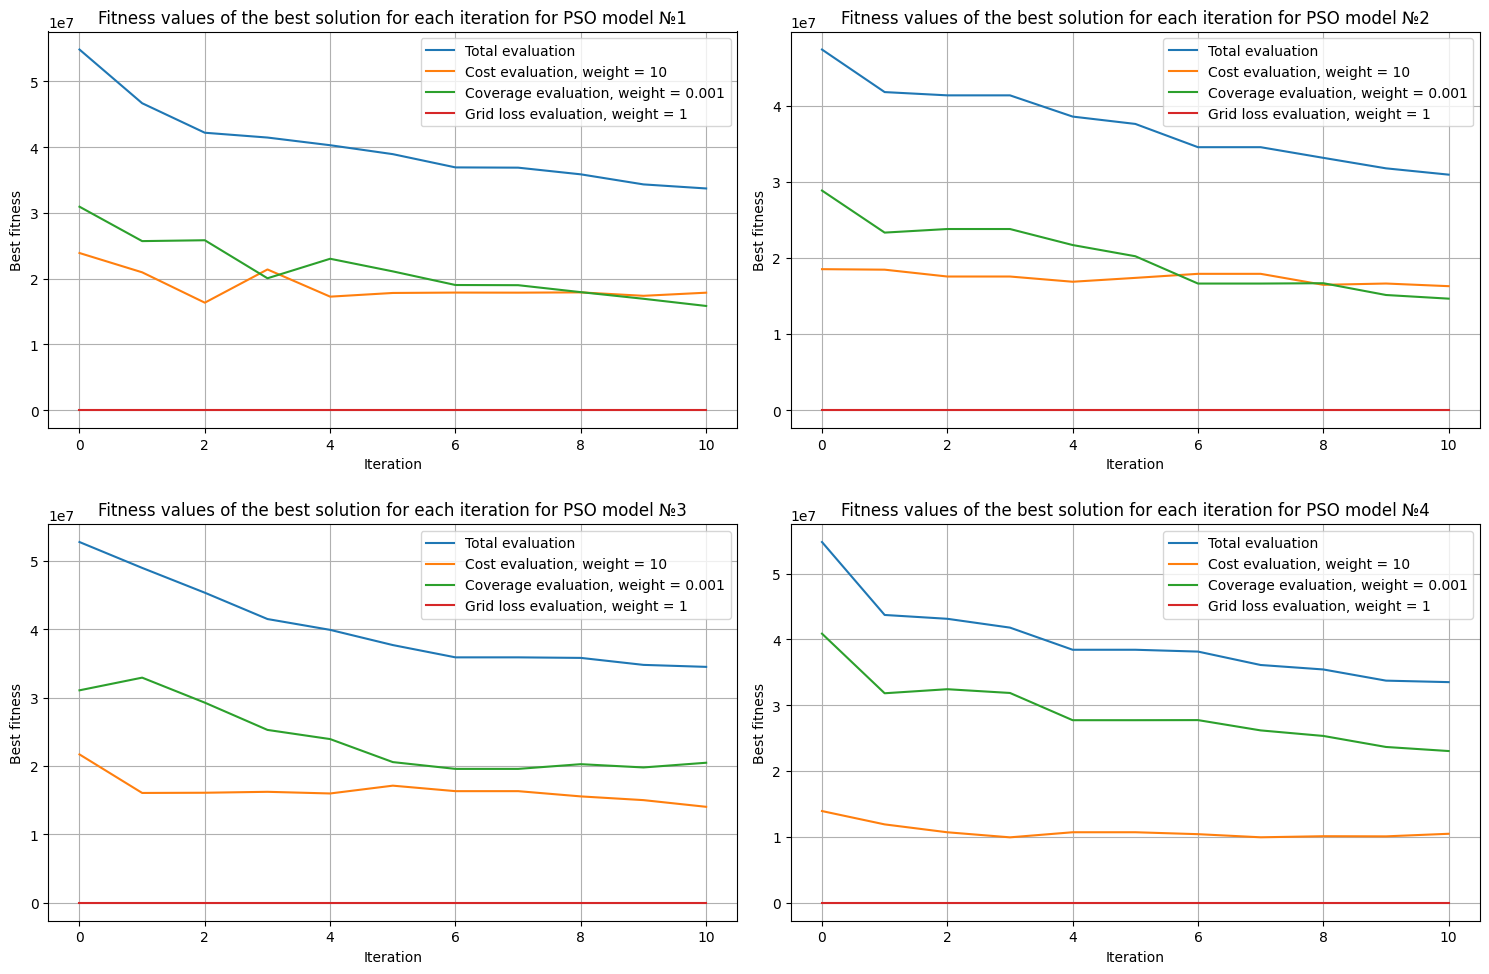

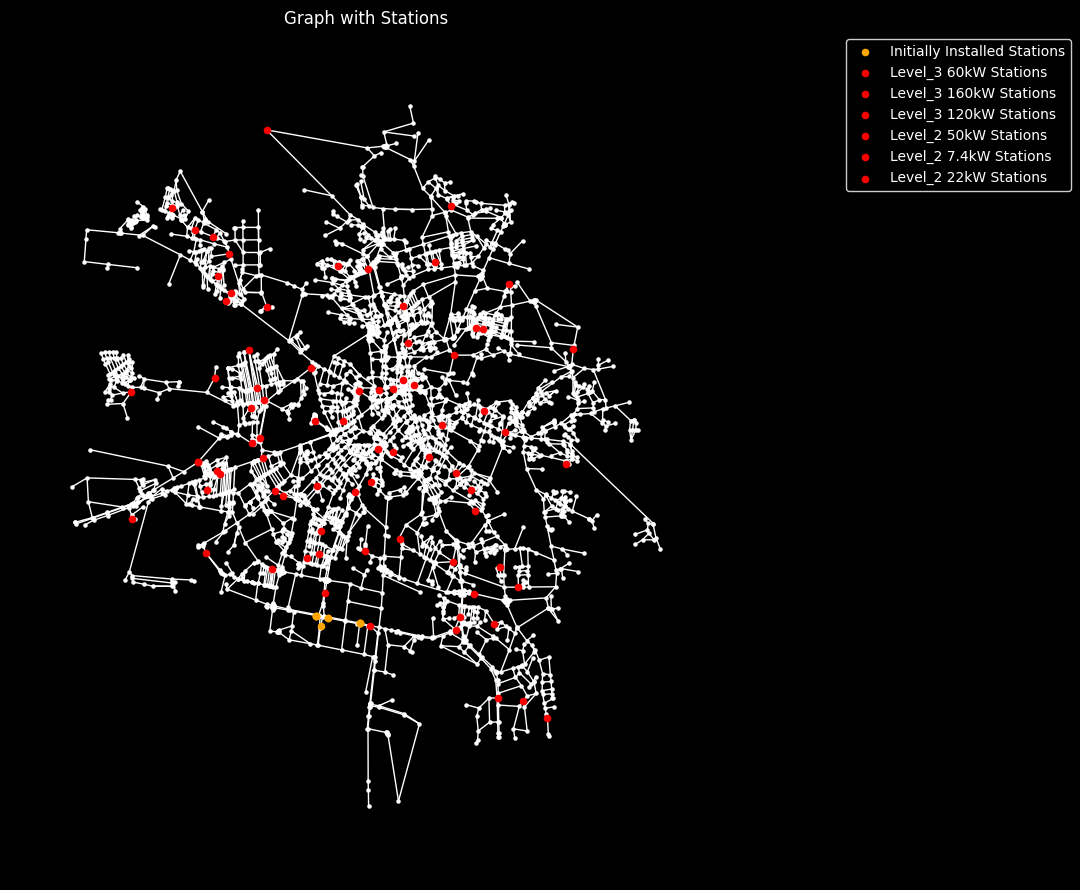

{(724004643, 'Level_3 60kW'): 1,
 (386666269, 'Level_3 160kW'): 2,
 (374456384, 'Level_3 120kW'): 1,
 (12392579826, 'Level_3 120kW'): 1,
 (361460952, 'Level_2 50kW'): 1,
 (722551456, 'Level_2 7.4kW'): 1,
 (267158856, 'Level_2 7.4kW'): 1,
 (513581271, 'Level_3 120kW'): 1,
 (1812339137, 'Level_3 160kW'): 1,
 (1642037184, 'Level_2 22kW'): 1,
 (6795969890, 'Level_2 7.4kW'): 2,
 (387997259, 'Level_2 22kW'): 2,
 (5174129847, 'Level_2 7.4kW'): 1,
 (4871507478, 'Level_2 22kW'): 1,
 (259742070, 'Level_2 22kW'): 2,
 (479846064, 'Level_2 22kW'): 1,
 (2096822897, 'Level_3 120kW'): 1,
 (1776961947, 'Level_3 120kW'): 1,
 (1954474291, 'Level_2 50kW'): 1,
 (387869855, 'Level_3 60kW'): 1,
 (8995381139, 'Level_3 60kW'): 2,
 (356264617, 'Level_3 60kW'): 1,
 (479846245, 'Level_2 50kW'): 1,
 (1587055091, 'Level_2 7.4kW'): 1,
 (7369354864, 'Level_3 60kW'): 1,
 (387999410, 'Level_3 60kW'): 1,
 (3661231798, 'Level_2 50kW'): 1,
 (6252622085, 'Level_3 120kW'): 1,
 (8093751747, 'Level_2 7.4kW'): 1,
 (7514855143,

In [69]:
PSO_model(city_data, EV_data, CS_data, model_parameters, n = 4)